In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from pyrocko.gf import LocalEngine, Target, DCSource, ws
from pyrocko import moment_tensor as pmt
from pyrocko import trace
from pyrocko.gui.marker import PhaseMarker

### some config

In [25]:
"""Config"""

channel_codes = 'Z'
quantity = 'velocity'
store_id = 'vogtland_malek2004_surface'
num = 200000
m_min = 0.
m_max = 3.
mag_uniform = True # uniform disrtribution of magnetudes
depth_lo = 1000.
depth_hi = 110. # somehow it crashes when depth is 100
r_stat = 500.
max_distance = 2000.
delta = 10.
p_id = 'rapidinv_p' # arrival ids from Green storage
s_id = 'rapidinv_s' # in this green store simpl p and s don't always work
datalen = 400 # data length in sampls, 0=event time
starts_at = [-100, 1] # wf start at rand[-100, 0]
file_name = '200k_wforms_06_10_22.hdf5'


In [26]:
"""functions"""
def get_mag(m_min=1, m_max=3, num=100, uniform=False):
    """ generating Ms
    # m_max = 3 max magnitude only 1 event
    # m_min = 1 min magnitude
    # num =  total number of events
    # law log(nn) = a-b*M
    # a = m_max * np.log10(num)/(m_max - m_min)
    # b = np.log10(num)/(m_max - m_min) """
    nn = np.random.rand(num) # randoms 0-1 size num
    if uniform:
        # magns = np.round(m_min + (m_max - m_min)*nn, 2) #list of magnitudes with G-R distribution
        magns = m_min + (m_max - m_min)*nn
    else:
        magns = np.round(m_min - (m_max - m_min)*np.log10(nn)/np.log10(num), 2) #list of magnitudes with G-R distribution
    return magns

def round_it(a, d):
    return np.sign(a)*(np.abs(a)//d*d)

def get_xy(num=10, r_stat=0, max_distance=1000, delta=10):
    """generates list of allowed coordinates"""
    rr = (max_distance - r_stat) * np.sqrt(np.around(np.random.rand(num), 4))
    phi = 2 * np.pi * np.around(np.random.rand(num), 4)
    xy = np.column_stack((round_it(rr * np.cos(phi), delta), round_it(rr * np.sin(phi), delta)))
    return xy

def get_sdr(num=10):
    """random strike dip rake"""
    sdr = np.array([np.round(pmt.random_strike_dip_rake(), 2) for ii in range(num)])
    return sdr

def get_depth(num=10, depth_lo=1000, depth_hi=0, delta=10):
    """random depth"""
    depth = round_it(depth_hi + np.random.rand(num)*(depth_lo-depth_hi), delta)
    return depth


def generate_events(num, m_min, m_max, mag_uniform, depth_lo, depth_hi, r_stat, max_distance, delta):
    """generating list of sources params"""
    mag = get_mag(m_min=m_min, m_max=m_max, num=num, uniform=mag_uniform) #magnitude
    sdr = get_sdr(num=num) # strike dip rake
    xy = get_xy(num=num, r_stat=r_stat, max_distance=max_distance, delta=delta) # coodrs
    depth = get_depth(num=num, depth_lo=depth_lo, depth_hi=depth_hi, delta=delta) # depth
    events = [{
        'x': xy[ii,0],
        'y': xy[ii,1],
        'depth': depth[ii],
        'strike': sdr[ii, 0],
        'dip': sdr[ii, 1],
        'rake': sdr[ii, 2],
        'magnitude':mag[ii]} for ii in range(num)]
    return events


In [27]:
"""list of locations"""
locations = [
    {'name':'sta1', 'x':r_stat, 'y':0., 'd':0.},
    {'name':'sta2', 'x':-r_stat, 'y':0., 'd':0.},
    {'name':'sta3', 'x':0., 'y':r_stat, 'd':0.},
    {'name':'sta4', 'x':0., 'y':-r_stat, 'd':0.},
]
"""list of station params"""
stations = [{
    'name':loc['name'],
    'store_id':store_id,
    'quantity':quantity,
    'channel_codes':channel_codes,
    'x':loc['x'],
    'y':loc['y'],
    'depth':loc['d']} for loc in locations]

"""list of event params"""
events = generate_events(num=num,
                         m_min=m_min,
                         m_max=m_max,
                         mag_uniform=mag_uniform,
                         depth_lo=depth_lo,
                         depth_hi=depth_hi,
                         r_stat=r_stat,
                         max_distance=max_distance,
                         delta=delta)


In [28]:
"""pyrocko engine"""
engine = LocalEngine(store_superdirs=['.'], default_store_id=store_id)
store = engine.get_store(store_id)

pbar = tqdm(total=len(events), desc='events processing') # progress bar

''''creating hdf5 file with all sht'''
if os.path.exists(file_name):
    os.remove(file_name)

with h5py.File(file_name, 'w') as f:
    '''creating structure of hdf5'''
    for s in stations:
        st = f.create_group(s['name'])
        tr = st.create_group('traces')
        for c in channel_codes:
            tr.create_dataset(f'{c}', (len(events), datalen), dtype='f')
        ar = st.create_group('arrivals')
        ar.create_dataset('p', (len(events),), dtype='f')
        ar.create_dataset('s', (len(events),), dtype='f')
        ar.create_dataset('strike', (len(events),), dtype='f')

    '''start of the simulation'''
    for ii, e in enumerate(events):
        source_dc = DCSource(
            east_shift = e['x'],
            north_shift = e['y'],
            depth=e['depth'],
            strike=e['strike'],
            dip=e['dip'],
            rake=e['rake'],
            magnitude=e['magnitude'])

        start_time = np.random.randint(starts_at[0], starts_at[1]) # random point at which waveform starts

        for s in stations:
            targets = [
                Target(
                    interpolation='multilinear',
                    quantity=s['quantity'],
                    east_shift = s['x'],
                    north_shift = s['y'],
                    depth=s['depth'],
                    store_id=s['store_id'],
                    codes=('', s['name'], '', channel_code))
                for channel_code in s['channel_codes']]

            response = engine.process(source_dc, targets)
            synthetic_traces = response.pyrocko_traces()

            '''first p and s arrivals and sampling rate'''
            p_time = store.t(p_id, (source_dc.depth, targets[0].distance_to(source_dc)))
            s_time = store.t(s_id, (source_dc.depth, targets[0].distance_to(source_dc)))

            sample_rate = int(1/synthetic_traces[0].deltat)
            s.setdefault('smpl_rate_hz', sample_rate) # sapl rate to stations info

            '''traces to file'''
            for t in synthetic_traces:
                '''zero = event time!!! len = datalen'''
                x = t.get_xdata() # время в секундах
                y = t.get_ydata() # сама волновая форма

                y[x<p_time] = 0 # Обнуляем всю ту ботву, что до вступления. С нормальной ГФ этого наверное не нужно

                my_trace = y[start_time<=np.round(x*sample_rate)][:datalen] # chop data NOTE x is float like 0.23000000001

                f[f"{t.station}/traces/{t.channel}"][ii,:] = my_trace

            '''phases to file'''
            f[f"{t.station}/arrivals/strike"][ii] = 0 - start_time/sample_rate
            f[f"{t.station}/arrivals/p"][ii] = p_time - start_time/sample_rate
            f[f"{t.station}/arrivals/s"][ii] = s_time - start_time/sample_rate

        pbar.update()

out_events  = pd.DataFrame(data = events) # events to DataFrame
out_stations = pd.DataFrame(data = stations) # stations to DataFrame

# dataframes to file
out_events.to_hdf(file_name, '/events')
out_stations.to_hdf(file_name, '/stations_info')

pbar.close()

events processing:   0%|          | 0/200000 [00:00<?, ?it/s]

<KeysViewHDF5 ['events', 'sta1', 'sta2', 'sta3', 'sta4', 'stations_info']>
<KeysViewHDF5 ['arrivals', 'traces']>
<KeysViewHDF5 ['Z']>
1.1998107
[1.1998107  0.38775793 1.0616403  ... 0.43901223 0.5768491  0.59445167]


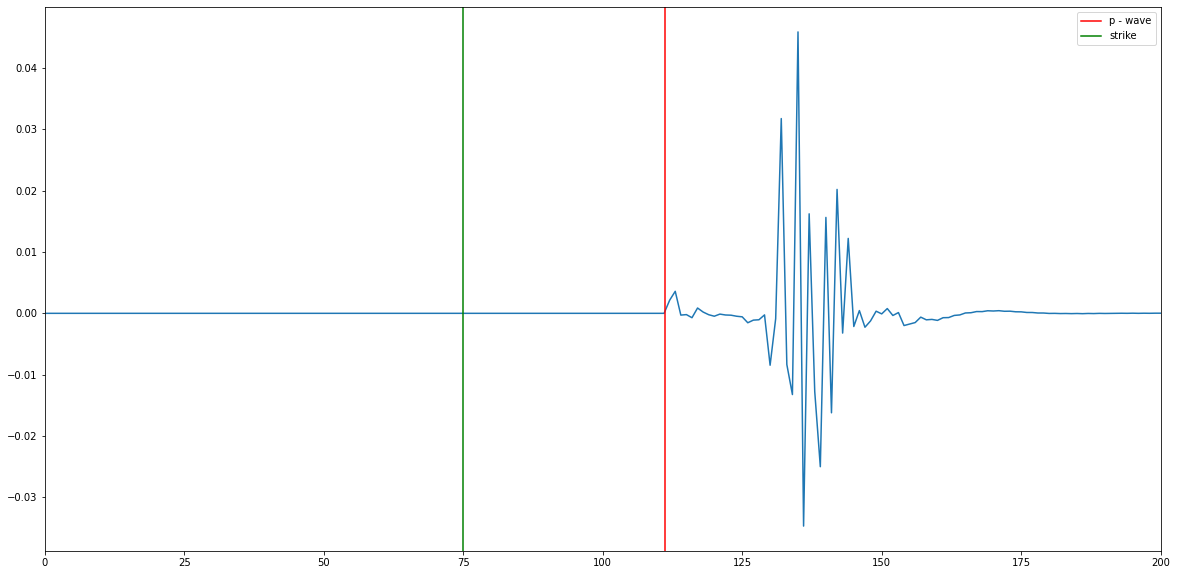

In [29]:
""" Testing """
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt


file_name = file_name


with h5py.File(file_name, 'r') as f:
    '''get root'''
    pp = f.keys()
    print(pp)

with h5py.File(file_name, 'r') as f:
    '''get list of sta1 items'''
    pp = f["sta1"].keys()
    print(pp)

with h5py.File(file_name, 'r') as f:
    '''get list of traces on sta1'''
    pp = f["sta1/traces"].keys()
    print(pp)

with h5py.File(file_name, 'r') as f:
    '''get sta1 Z channel first trace'''
    pp = f["sta1/traces/Z"][0]
    # print(pp)

with h5py.File(file_name, 'r') as f:
    '''get its p arrival'''
    pp = f["sta1/arrivals/p"][0]
    print(pp)


with h5py.File(file_name, 'r') as f:
    '''get list of p arrivals on sta1'''
    pp = f["sta1/arrivals/p"][:]
    print(pp)

'''how to get station_info DataFrame'''
si = pd.read_hdf(file_name, '/stations_info')
si.head()

'''how to get events'''
arr = pd.read_hdf(file_name, '/events')
arr.head()

'''sample'''
sample_rate = si['smpl_rate_hz'][0]

fig, ax = plt.subplots(1,1)
fig.set_size_inches(20,10)
ax.set_xlim(0,200)

trace_no = 8
with h5py.File(file_name, 'r') as f:
    ax.plot(f["sta1/traces/Z"][trace_no])
    plt.axvline(x=f["sta1/arrivals/p"][trace_no]*sample_rate, color='r', label = 'p - wave')
    plt.axvline(x=f["sta1/arrivals/strike"][trace_no]*sample_rate, color='g', label = 'strike')
    plt.legend()



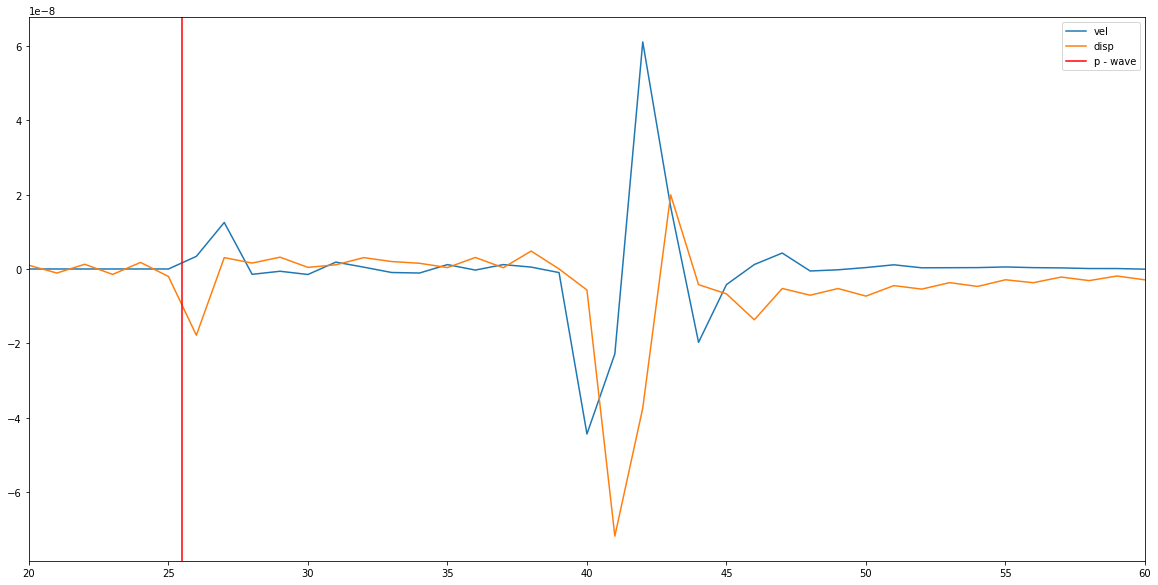

In [14]:
"""Some more testing not for sale"""
engine = LocalEngine(store_superdirs=['.'], default_store_id=store_id)
store = engine.get_store(store_id)

e = events[0]
source_dc = DCSource(
    east_shift = e['x'],
    north_shift = e['y'],
    depth=e['depth'],
    strike=e['strike'],
    dip=e['dip'],
    rake=e['rake'],
    magnitude= 0 )#e['magnitude'])

s = stations[0]
targets = [
    Target(
    interpolation='multilinear',
    quantity=q,
    east_shift = s['x'],
    north_shift = s['y'],
    depth=s['depth'],
    store_id=s['store_id'],
    codes=('', s['name'], '', 'Z'))
    for q in ['velocity','displacement']]

response = engine.process(source_dc, targets)
synthetic_traces = response.pyrocko_traces()

'''first p and s arrivals and sampling rate'''
p_time = store.t(p_id, (source_dc.depth, targets[0].distance_to(source_dc)))
s_time = store.t(s_id, (source_dc.depth, targets[0].distance_to(source_dc)))
sample_rate = int(1/synthetic_traces[0].deltat)

'''traces'''
dis_t = synthetic_traces[1]
vel_t = synthetic_traces[0]

x = dis_t.get_xdata() # время в секундах
dis = dis_t.get_ydata().copy() # смещение
vel = vel_t.get_ydata().copy() # скорость


vel[x<p_time] = 0 # Обнуляем всю ту ботву, что до вступления.
d = dis[0<=np.round(x*sample_rate)][:datalen] # chop data NOTE x is float like 0.23000000001
v = vel[0<=np.round(x*sample_rate)][:datalen]

fig, ax = plt.subplots(1,1)
fig.set_size_inches(20,10)
ax.set_xlim(20,60)

ax.plot(v/sample_rate, label='vel')
ax.plot(d, label='disp')
plt.axvline(x=p_time*sample_rate, color='r', label = 'p - wave')
plt.legend()